# Deconvolution and spectral indices
We assume that you have created the hdf5 file of calibrated data and the mask defining the sediment.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

import h5py

import spectral
from spectral import remove_continuum

from hyperspec.calib.bil_reader import BilReader
from hyperspec.file_finder import FileFinder
from hyperspec.util import scale_image

## get the hdf file and mask
We use the mask and hdf file from the previous notebook

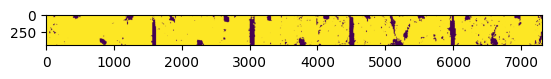

In [2]:
try:
    from _local import path_file_hdf5_iceland, path_file_mask_foreground_iceland, path_folder_iceland
    path_file_hdf5 = path_file_hdf5_iceland
    path_mask = path_file_mask_foreground_iceland
    path_folder_capture = path_folder_iceland
except:  # specify your files here
    path_file_hdf5 = ...
    path_mask = ...
    path_folder_capture = ...

mask_valid = np.load(path_mask)

plt.imshow(mask_valid.T)

In [3]:
ff = FileFinder(path_folder_capture)
bil_reader  = BilReader(
    path_file_header=ff.path_meas_header_file,
    path_file_binary=ff.path_meas_binary_file
)

## Sub-RoI definition
We define a 20 pixel wide section in the middle of the RoI to be used for spectral analysis.

In [4]:
hdf = h5py.File(path_file_hdf5, 'r')

dataset = hdf['roi_calibrated']

# place 20 pixel wide region for spectral processing at the center
width_roi = 20
row_start = 0
row_end = dataset.shape[0]
col_start = round(dataset.shape[1] / 2 - width_roi / 2)
col_end = col_start + width_roi
roi = dataset[row_start:row_end, col_start:col_end, :]
mask_valid_roi = mask_valid[row_start:row_end, col_start:col_end]

In [6]:
rgb_channels = [np.argmin(np.abs(wv - bil_reader.wavelengths_nm)) for wv in bil_reader.rgb_wavelengths]
rgb_img = np.stack([dataset[:, :, rgb_channel] for rgb_channel in rgb_channels], axis=-1)
rgb_roi = roi[:, :, rgb_channels]

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:107: RuntimeWarning: overflow encountered in cast
  get_virtual_index=lambda n, quantiles: (n - 1) * quantiles,
C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4750: RuntimeWarning: overflow encountered in cast
  indexes_above_bounds = virtual_indexes >= valid_values_count - 1
C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4655: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in scalar multiply
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


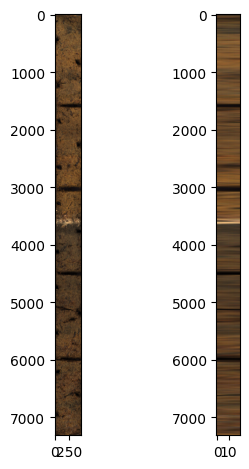

In [7]:
### plot imcube and ROI
fig, axs = plt.subplots(nrows=1, ncols=2, layout='tight')

axs[0].imshow(scale_image(rgb_img).astype(float))
axs[1].imshow(scale_image(rgb_roi).astype(float), aspect=1 / 20)

In [8]:
bands = bil_reader.wavelengths_nm

 # Spectral analysis on reduced data

mnf and PPI can be performed with `napari-sediment` as well but we lack some of the flexibility that we would like to have. Since it is based on the `spectral` library, we can make those calls here explicitly.

## MNF

In [10]:
print('calcing stats ...')
signal = spectral.calc_stats(roi, mask_valid_roi)
print('calcing noise ...')
noise = spectral.noise_from_diffs(roi)
print('calcing nmf ...')
mnfr = spectral.mnf(signal, noise)
print('done!')

calcing stats ...


C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:554: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)


calcing noise ...
calcing nmf ...
done!


In [11]:
signal.cov.shape

(476, 476)

plot some of the eigenvectors (in columns according to documentation)

creating plot ...


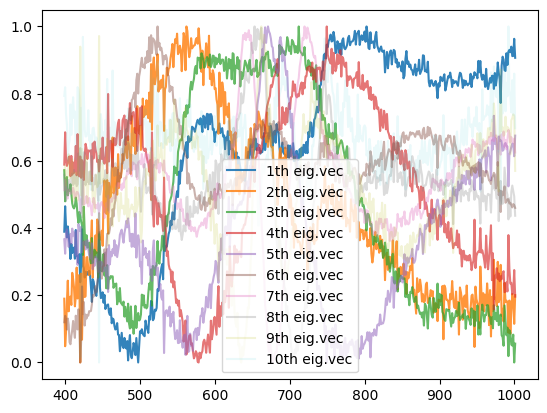

In [12]:
print('creating plot ...')
n_vecs = 10
plt.figure()
lams = bil_reader.wavelengths_nm
for i in range(n_vecs):
    v = mnfr.napc.eigenvectors[:, i].copy()
    v -= v.min()
    v /= v.max()
    plt.plot(lams, v, alpha=1 - (i + 1) / (n_vecs + 1), label=f'{i + 1}th eig.vec')
plt.legend()

plot eigenvalues

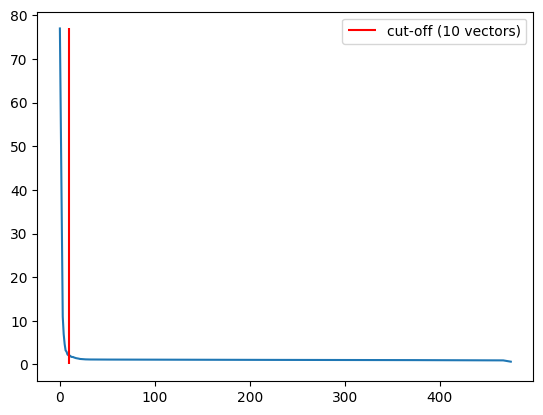

In [13]:
plt.plot(mnfr.napc.eigenvalues)
plt.vlines(n_vecs, 0, mnfr.napc.eigenvalues.max(), colors='red', label=f'cut-off ({n_vecs} vectors)')
plt.legend()

In [14]:
# De-noise the data by eliminating NAPC components where SNR < 10.
# The de-noised data will be in the original coordinate space (at
# full dimensionality).
print('denoising ...')
denoised_mnf = mnfr.denoise(roi, num=n_vecs)

denoising ...


### Reduce dimensionality, retaining top NAPC components.

In [17]:
reduced = mnfr.reduce(roi, num=n_vecs)

In [18]:
reduced.shape

(7310, 20, 10)

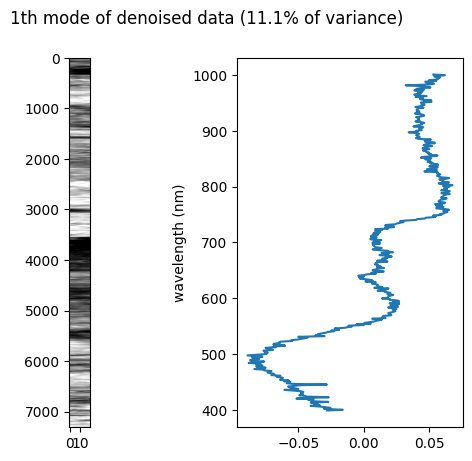

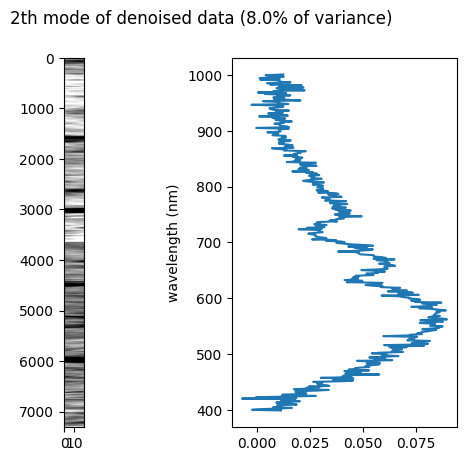

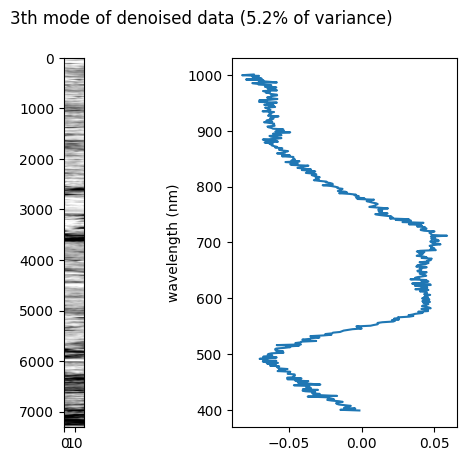

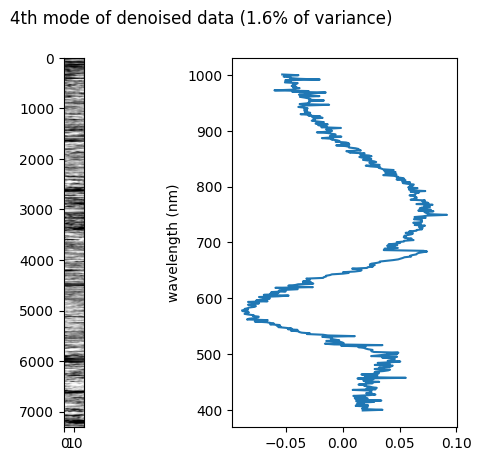

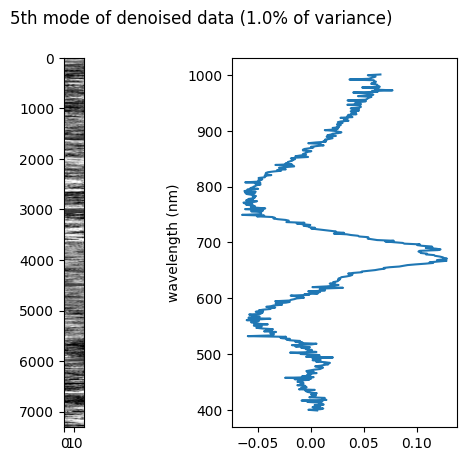

In [19]:
for i in range(min([n_vecs, 5])):
    fig, axs = plt.subplots(ncols=2)
    img = reduced[:, :, i]
    axs[0].imshow(img, vmin=np.quantile(img, .05), vmax=np.quantile(img, .95), aspect=1 / 20, cmap='grey')
    axs[1].plot(mnfr.napc.eigenvectors[:, i], lams)
    axs[1].set_ylabel('wavelength (nm)')
    fig.suptitle(
        f'{i + 1}th mode of denoised data ({mnfr.napc.eigenvalues[i] / mnfr.napc.eigenvalues.sum():.1%} of variance)')

## endmember idenfitication

### pixel purity index

Running 1000 pixel purity iterations...done   


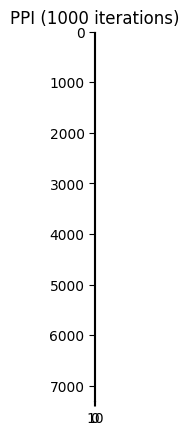

In [20]:
from scipy.signal import savgol_filter

n_iters_ppi = 1000
counts = spectral.algorithms.ppi(reduced, niters=n_iters_ppi, centered=False, display=1)

In [21]:
# number of counts
thr_counts = n_iters_ppi / 30
mask_ppi = counts > thr_counts
endmembers = denoised_mnf[mask_ppi]
print(f'detected {endmembers.shape[0]} endmembers')

detected 2 endmembers


(np.uint32(0), np.uint32(44), np.float64(0.013679890560875513))

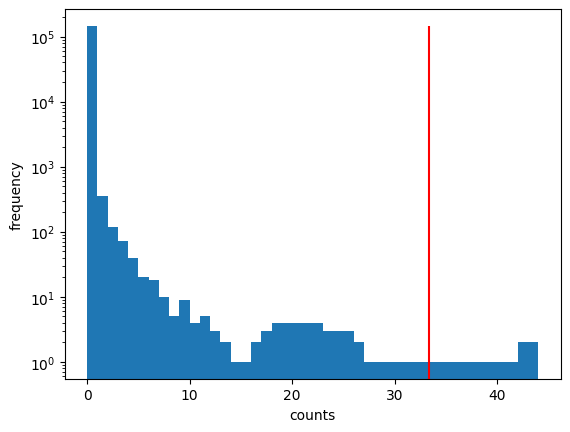

In [22]:
# how are counts distributed? ideally we have few pixels with high counts
ret = plt.hist(counts.ravel(), bins=np.unique(counts), log=True)
plt.vlines(thr_counts, 0, ret[0].max(), colors='red')
plt.xlabel('counts')
plt.ylabel('frequency')
counts.min(), counts.max(), counts.mean()

Text(0.5, 0, 'Wavelength (nm)')

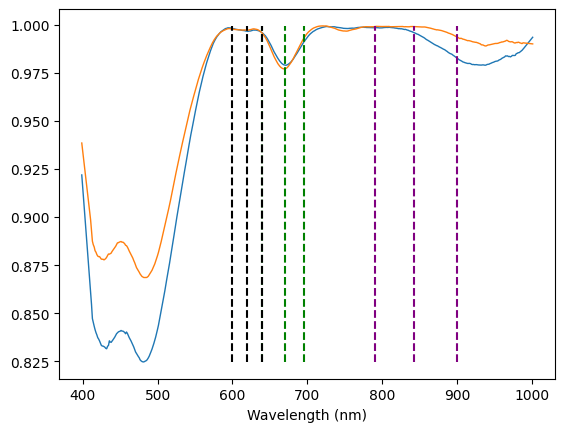

In [23]:
a = np.inf
b = -np.inf
for i in range(endmembers.shape[0]):
    y = remove_continuum(endmembers[i, :], bands=bands)
    y = savgol_filter(y, window_length=21, polyorder=1)
    if y.min() < a:
        a = y.min()
    if y.max() > b:
        b = y.max()
    plt.plot(bands, y, linewidth=1)
# Chl-a trough
plt.vlines([640, 670, 695], a, b, linestyles='--', colors='green')
#BChl-a trough
plt.vlines([790, 900, 842], a, b, linestyles='--', colors='purple')
# Phycocyanin trough
plt.vlines([620, 639, 600], a, b, linestyles='--', colors='black')
plt.xlabel('Wavelength (nm)')

### K-means

In [61]:
from sklearn.cluster import KMeans
import math

kmeans_on_denoised = True
kmeans_on_reduced = True
kmeans_on_normalized = False  # continuum contains information of total reflectance, which is useful information


def get_reduced_and_normalized(data):
    if kmeans_on_denoised:
        # assert not (kmeans_on_reduced or kmeans_on_normalized)
        data = mnfr.denoise(data, num=n_vecs)
    if kmeans_on_normalized:
        data = remove_continuum(data, bands=bands)
        # data = remove_avg_continuum(data)
        # data /= data.mean(axis=(0, 1))
    if kmeans_on_reduced:
        data = mnfr.reduce(data, num=n_vecs)
    return data


data_kmeans = get_reduced_and_normalized(roi)
data_kmeans[np.isnan(data_kmeans)] = 0
# reshape and mask
X_kmeans = data_kmeans[mask_valid_roi]

Text(0.5, 0, 'MNF dimension')

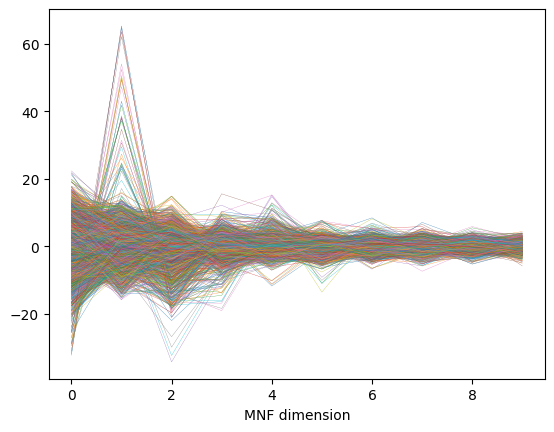

In [62]:
# make sure our X looks somewhat reasonable
n_test = 2000

for i in np.random.choice(range(X_kmeans.shape[0]), n_test, replace=False):
    plt.plot(X_kmeans[i, :], linewidth=.2)
plt.xlabel('MNF dimension')


#### find right number of clusters via silhoutte coefficient

In [63]:
from sklearn.metrics import silhouette_score

n_clusters_max = 10
clusters_to_test = np.arange(2, n_clusters_max + 1)

print('starting silhoutte calculation')
res = {}
for n_clusters in clusters_to_test:
    kmeans_sk = KMeans(n_clusters=n_clusters)
    cluster_labels = kmeans_sk.fit_predict(X_kmeans)
    silhouette_avg = silhouette_score(X_kmeans, cluster_labels, sample_size=1000)
    res[n_clusters] = (silhouette_avg, kmeans_sk)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

starting silhoutte calculation
For n_clusters = 2 The average silhouette_score is : 0.25193720609255255
For n_clusters = 3 The average silhouette_score is : 0.23369266085292975
For n_clusters = 4 The average silhouette_score is : 0.28448516908214166
For n_clusters = 5 The average silhouette_score is : 0.20674026627336337
For n_clusters = 6 The average silhouette_score is : 0.21794727259042404
For n_clusters = 7 The average silhouette_score is : 0.1908826990678627
For n_clusters = 8 The average silhouette_score is : 0.16909099170273167
For n_clusters = 9 The average silhouette_score is : 0.17185150408072997
For n_clusters = 10 The average silhouette_score is : 0.17481633036053498


In [64]:
# we want the highest silhoutte coefficient
idx = np.argmax([r[0] for r in res.values()])
# n_clusters_best = clusters_to_test[idx]
n_clusters_best = 4
kmeans_sk = res[n_clusters_best][1]
print(f'the highest scoring option is {n_clusters_best} clusters')

the highest scoring option is 4 clusters


In [65]:
# already fitted, so we can just predict (even the holes
labels = kmeans_sk.predict(data_kmeans.reshape(math.prod(reduced.shape[:2]), -1)).reshape(reduced.shape[:2])

In [66]:
# add new label for holes
# for ngist colormap it makes sense to set this label to the highest value since it appears as white
labels[~mask_valid_roi] = labels.max() + 1
u_labels = np.unique(labels)
n_labels = len(u_labels)

# use denoised (and normalized) to recalculate cluster centers
centers_kmeans = np.zeros((n_labels, roi.shape[2]))

if kmeans_on_normalized:
    for_centers = remove_continuum(roi, bands=bands)
else:
    for_centers = roi

for i, l in enumerate(u_labels):
    mask_label = labels == l
    centers_kmeans[i, :] = for_centers[mask_label, :].mean(axis=0)

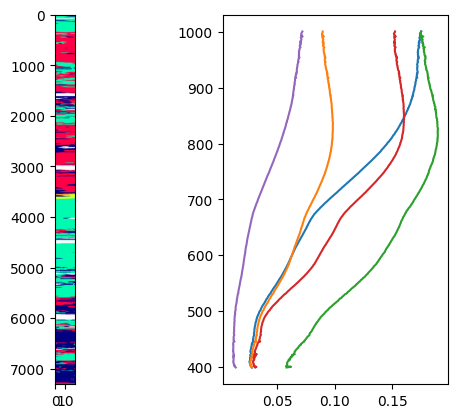

In [67]:
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(labels, aspect=1 / 20, cmap='gist_ncar')
for i in range(centers_kmeans.shape[0]):
    axs[1].plot(centers_kmeans[i, :], bands)

#### extent kmeans annotations to entire image

In [68]:
print('this will take a while and a lot of memory ...')
print('converting to np array ...')
imcube_for_pred = np.asarray(dataset, dtype=float)
if kmeans_on_normalized:
    print('removing continuum ...')
    imcube_for_pred = remove_continuum(imcube_for_pred, bands=bands)
    if kmeans_on_reduced:
        print('reducing ...')
        imcube_for_pred = mnfr.reduce(imcube_for_pred, num=n_vecs)
elif kmeans_on_reduced:
    print('reducing ...')
    imcube_for_pred = mnfr.reduce(imcube_for_pred, num=n_vecs)
imcube_for_pred[np.isnan(imcube_for_pred)] = 0
print('Done!')

this will take a while and a lot of memory ...
converting to np array ...
reducing ...
Done!


make sure spectra in imcube look similar to those of the ROI used to fit K-Means

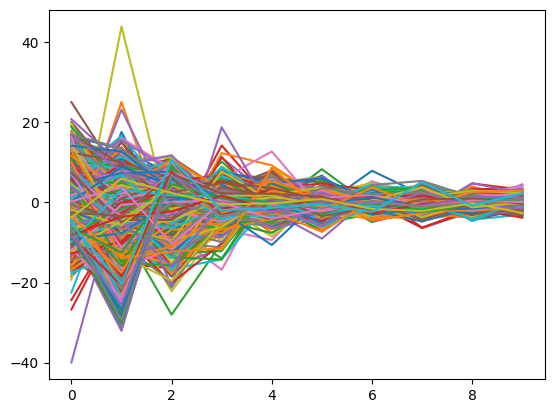

In [69]:
n_test = 1000
random_indices = list(zip(
    np.random.choice(np.arange(imcube_for_pred.shape[0]), size=n_test),
    np.random.choice(np.arange(imcube_for_pred.shape[1]), size=n_test)
))

for i, j in random_indices:
    spec = imcube_for_pred[i, j, :]
    plt.plot(spec)

In [70]:
from tqdm import tqdm

ncols, nrows = dataset.shape[:2]

I, J = np.meshgrid(range(ncols), range(nrows))
ij = zip(I.ravel(), J.ravel())

if not kmeans_on_reduced:
    print('only works for not reduced, would need some other method otherwise')

labels_full = np.zeros((ncols, nrows))

label_invalid = labels.max()
for i, j in tqdm(ij, total=ncols * nrows):
    if not mask_valid[i, j]:
        labels_full[i, j] = label_invalid
    else:
        labels_full[i, j] = kmeans_sk.predict(imcube_for_pred[i, j, :].reshape(1, -1))[0]

100%|██████████| 3289500/3289500 [01:58<00:00, 27818.92it/s]


In [71]:
np.unique(labels_full, return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([ 807470, 1162327,   28743,  968997,  321963]))

C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:107: RuntimeWarning: overflow encountered in cast
  get_virtual_index=lambda n, quantiles: (n - 1) * quantiles,
C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4750: RuntimeWarning: overflow encountered in cast
  indexes_above_bounds = virtual_indexes >= valid_values_count - 1
C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4655: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
C:\Users\Yannick Zander\Nextcloud2\Promotion\hyperspec\hyperspec\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4656: RuntimeWarning: invalid value encountered in scalar multiply
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


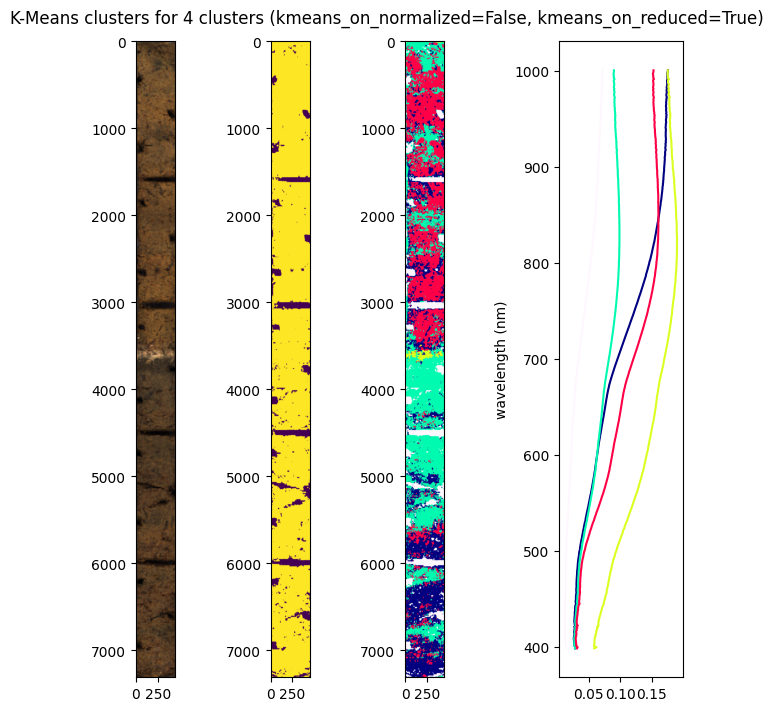

In [72]:
import matplotlib

remove_continuum_if_not_on_normalized = False

fig, axs = plt.subplots(ncols=4, sharey=False, layout='constrained', figsize=(6, 7))
axs[0].imshow(scale_image(rgb_img).astype(float))
axs[1].imshow(mask_valid)
axs[2].imshow(labels_full, cmap='gist_ncar')

cmap = matplotlib.colormaps['gist_ncar']
n_centers = centers_kmeans.shape[0]
for i in range(n_centers):
    y = centers_kmeans[i, :]
    if remove_continuum_if_not_on_normalized and (not kmeans_on_normalized):
        y = remove_continuum(y, bands=bands)
    axs[3].plot(y, bands, c=cmap(i / (n_centers - 1)))

# add bars for rgb channels
wl_rgb = bands[rgb_channels]
# axs[3].hlines(wl_rgb, 0, centers_kmeans.max, colors=['r', 'g', 'b'])

axs[3].set_ylabel('wavelength (nm)')
axs[3].set_title('')
fig.suptitle(f'K-Means clusters for {n_clusters_best} clusters ({kmeans_on_normalized=}, {kmeans_on_reduced=})')
fig.savefig('clusters.pdf')

## Spectral indices

In [36]:
def get_img_for_wavelength(lam, array3D):
    idx = np.argmin(np.abs(bands - lam))

    return array3D[:, :, idx].astype(float)

def NDCI(array3D):
    """Normalized difference chlorophyll index"""
    R_705 = get_img_for_wavelength(705, array3D)
    R_665 = get_img_for_wavelength(670, array3D)
    return (R_705 - R_665) / (R_705 + R_665)

def RABD670(array3D):
    """Chl-a from https://bg.copernicus.org/articles/20/2221/2023/"""
    R_670 = get_img_for_wavelength(670, array3D)
    R_640 = get_img_for_wavelength(640, array3D)
    R_695 = get_img_for_wavelength(695, array3D)
    return ((19 * R_640 + 16 * R_695) / 35 / R_670)

def RABD842(array3D):
    """BChl-a from https://bg.copernicus.org/articles/20/2221/2023/"""
    R_790 = get_img_for_wavelength(790, array3D)
    R_900 = get_img_for_wavelength(900, array3D)
    R_842 = get_img_for_wavelength(695, array3D)
    return ((33 * R_790 + 36 * R_900) / 99 / R_842)

def RABD620(array3D):
    """phycocyanin"""
    center = 620
    left = 600
    right = 640
    R_center = get_img_for_wavelength(center, array3D)
    R_left = get_img_for_wavelength(left, array3D)
    R_right = get_img_for_wavelength(right, array3D)
    X_right = right - center
    X_left = center - left
    return ((X_right * R_left + X_left * R_right) / (X_right + X_left) / R_center)

def CI(array3D):
    """Cyanobacteria index"""
    R_560 = get_img_for_wavelength(560, array3D)
    R_665 = get_img_for_wavelength(665, array3D)
    R_705 = get_img_for_wavelength(705, array3D)
    return -((R_665 - R_560) - (R_705 - R_560) * (665 - 560) / (705 - 560))

def PHY(array3D):
    return get_img_for_wavelength(620, array3D)

In [53]:
def plot_index(img, fig=None, axs=None):
    if axs is None:
        fig, axs = plt.subplots(ncols=2, sharey=True, layout='tight', figsize=(4, 8))

    img[~mask_valid] = np.nan

    mask_rows = (~np.isnan(img)).mean(axis=1) > .1
    axs[0].imshow(scale_image(img))
    axs[1].plot(np.nanmean(img[mask_rows, :], axis=1), np.arange(phy.shape[0])[mask_rows], c='k', linewidth=.25)
    axs[1].set_xlabel('index')
    axs[0].set_ylabel('Depth (cm)')
    return fig, axs

In [54]:
ndci = NDCI(dataset)
ndci[~mask_valid] = np.nan

chl_a = RABD670(dataset)
chl_a[~mask_valid] = np.nan

bchl_a = RABD842(dataset)
bchl_a[~mask_valid] = np.nan

ci = CI(dataset)
ci[~mask_valid] = np.nan

phy = RABD620(dataset)
phy[~mask_valid] = np.nan

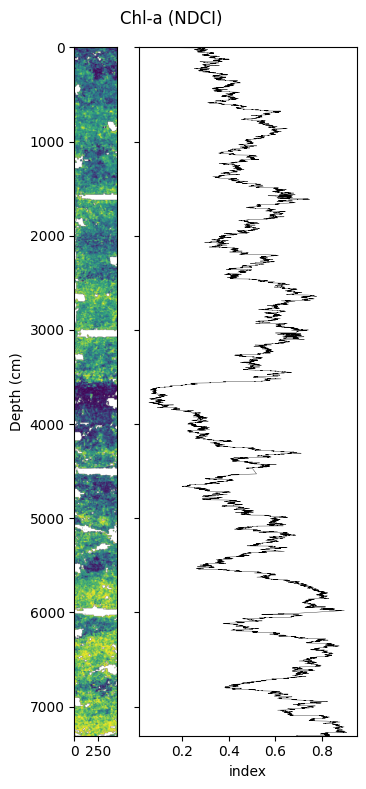

In [57]:
# scale
fig, axs = plot_index(ndci)
fig.suptitle('Chl-a (NDCI)')
# plt.savefig("NDCI.png", dpi=300)

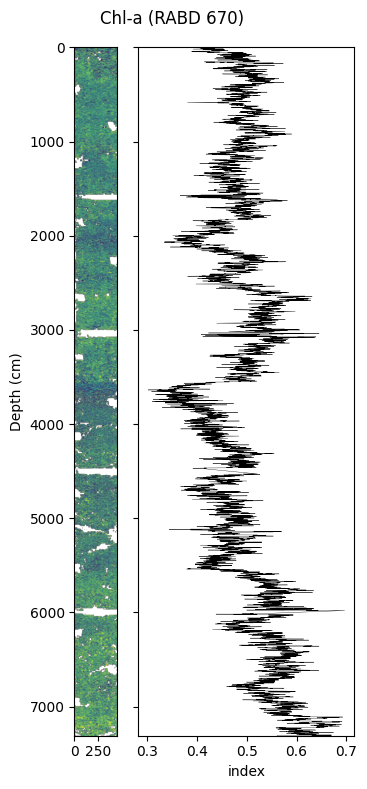

In [58]:
fig, axs = plot_index(chl_a)
fig.suptitle('Chl-a (RABD 670)')
# plt.savefig("RABD670.png", dpi=300)

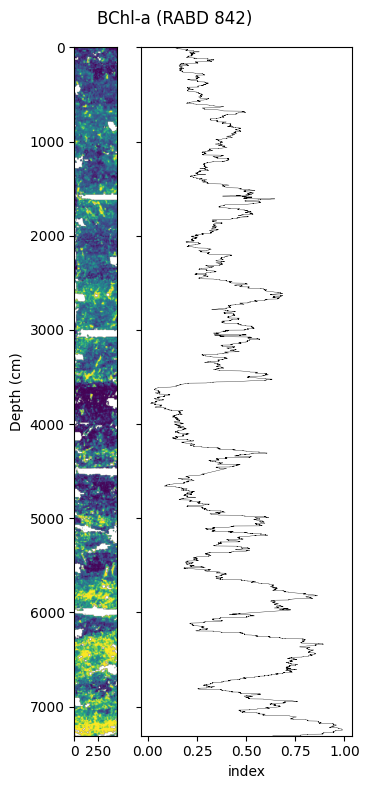

In [59]:
fig, axs = plot_index(bchl_a)
fig.suptitle('BChl-a (RABD 842)')
# plt.savefig("RABD842.png", dpi=300)

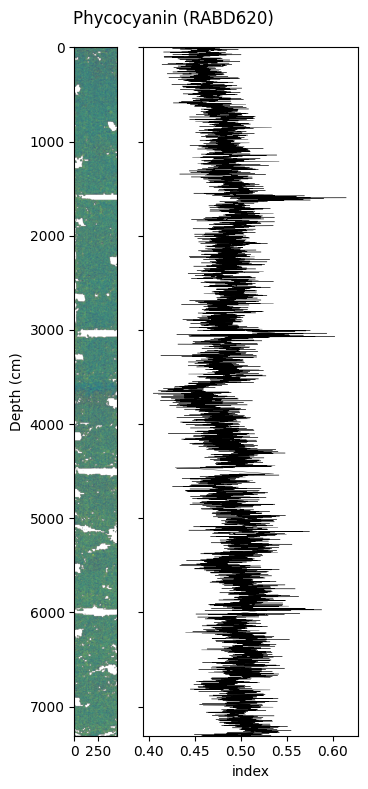

In [60]:
# scale
fig, axs = plot_index(phy)
fig.suptitle('Phycocyanin (RABD620)')
# plt.savefig("RABD620.png", dpi=300)